In [1]:
import numpy as np
import pandas as pd
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [2]:
class OHLCV:
    def __init__(self, o, h, l, c, v, t=None):
        self.open = o
        self.high = h
        self.low = l
        self.close = c
        self.volume = v
        self.time = t

# Raw Data from Indodax

In [3]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'

def get_raw(period, begin, end):
    chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, begin, end)
    raw = requests.get(root_uri_chart_api + chart_query).json()
    return OHLCV(
        np.array(raw['o']),
        np.array(raw['h']),
        np.array(raw['l']),
        np.array(raw['c']),
        np.array(raw['v']),
        t=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), raw['t']))
    )


In [4]:
train_set = get_raw(5, int(datetime.datetime(2015, 11, 1).timestamp()), int(datetime.datetime(2016, 5, 1).timestamp()))

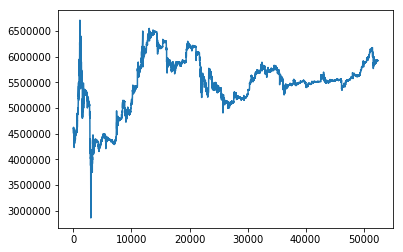

In [5]:
plt.plot(train_set.close)

In [6]:
test_up_set = get_raw(5, int(datetime.datetime(2017, 10, 1).timestamp()), int(datetime.datetime(2017, 12, 1).timestamp()))

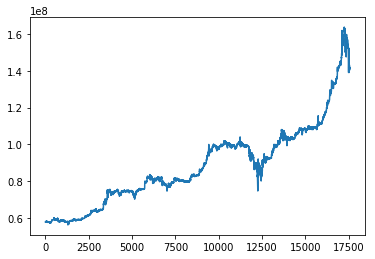

In [7]:
plt.plot(test_up_set.close)

In [8]:
test_down_set = get_raw(5, int(datetime.datetime(2018, 1, 1).timestamp()), int(datetime.datetime(2018, 3, 1).timestamp()))

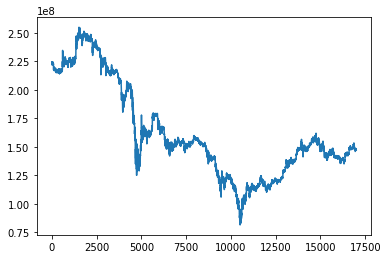

In [9]:
plt.plot(test_down_set.close)

In [238]:
test_updown_set = get_raw(5, int(datetime.datetime(2016, 8, 10).timestamp()), int(datetime.datetime(2016, 10, 10).timestamp()))

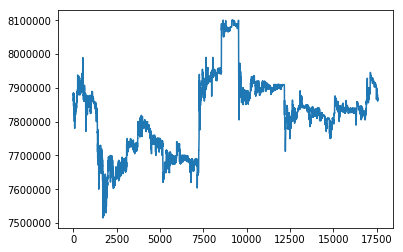

In [239]:
plt.plot(test_updown_set.close)

In [46]:
EPS = 1e-6
BUY = -1
HOLD = 0
SELL = 1
commission = 0.003

# Label Method 1

In [241]:
def get_label_1(raw, look_back, margin):
    N = len(raw.close) - look_back
    action = np.array([0 for i in range(N)], dtype=np.int16)
    for i in range(N):
        current = raw.close[i]
        before = raw.close[i-1]
        after = raw.close[i+1]
        if current * (1 + margin) < after:
            if before * (1 + margin) < current:
                action[i] = HOLD
            else:
                action[i] = BUY
        elif current > after * (1 + margin):
            if before > current * (1 + margin):
                action[i] = HOLD
            else:
                action[i] = SELL
        else:
            action[i] = HOLD
    return action

In [242]:
label_train = get_label_1(train_set, 10, commission)
label_up_test = get_label_1(test_up_set, 10, commission)
label_down_test = get_label_1(test_down_set, 10, commission)
label_updown_test = get_label_1(test_updown_set, 10, commission*2)

In [257]:
np.savetxt('y_train_label1.csv', label_train+1, delimiter=',')
np.savetxt('y_up_test_label1.csv', label_up_test+1, delimiter=',')
np.savetxt('y_down_test_label1.csv', label_down_test+1, delimiter=',')
np.savetxt('y_updown_test_label1.csv', label_updown_test+1, delimiter=',')

(array([  907.,     0.,     0.,     0.,     0., 13989.,     0.,     0.,
            0.,  2087.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

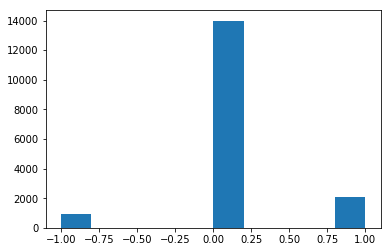

In [230]:
plt.hist(label_down_test)

# Backtrading

In [42]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [133]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.opsize = order.executed.size
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                gross_pnl = (order.executed.price - self.buyprice) * \
                    self.opsize

                net_pnl = gross_pnl - self.buycomm - order.executed.comm
                self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                         (gross_pnl, net_pnl))


            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

In [231]:
action_frame_train = pd.DataFrame({
    'low': label_train,
    'close': train_set.close[:len(label_train)],
    'open': train_set.open[:len(label_train)],
    'high': train_set.high[:len(label_train)],
}, index=train_set.time[:len(label_train)])

In [232]:
action_frame_up = pd.DataFrame({
    'low': label_up_test,
    'close': test_up_set.close[:len(label_up_test)],
    'open': test_up_set.open[:len(label_up_test)],
    'high': test_up_set.high[:len(label_up_test)],
}, index=test_up_set.time[:len(label_up_test)])

In [233]:
action_frame_down = pd.DataFrame({
    'low': label_down_test,
    'close': test_down_set.close[:len(label_down_test)],
    'open': test_down_set.open[:len(label_down_test)],
    'high': test_down_set.high[:len(label_down_test)],
}, index=test_down_set.time[:len(label_down_test)])

In [234]:
action_frame_updown = pd.DataFrame({
    'low': label_updown_test,
    'close': test_updown_set.close[:len(label_updown_test)],
    'open': test_updown_set.open[:len(label_updown_test)],
    'high': test_updown_set.high[:len(label_updown_test)],
}, index=test_updown_set.time[:len(label_updown_test)])

In [243]:
data_feed = btfeeds.PandasData(dataname=action_frame_updown, openinterest=None)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(80 * 10**6)
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 80000000.00
2016-08-10, BUY CREATE
2016-08-10, BUY EXECUTED, Price: 7780000.00, Cost: 7780000.00, Comm 23340.00
2016-08-10, SELL CREATE
2016-08-10, SELL EXECUTED, Price: 7840100.00, Cost: 7780000.00, Comm 23520.30
2016-08-10, OPERATION PROFIT, GROSS 60100.00, NET 13239.70
2016-08-15, BUY CREATE
2016-08-15, BUY EXECUTED, Price: 7600000.00, Cost: 7600000.00, Comm 22800.00
2016-08-15, SELL CREATE
2016-08-15, SELL EXECUTED, Price: 7723900.00, Cost: 7600000.00, Comm 23171.70
2016-08-15, OPERATION PROFIT, GROSS 123900.00, NET 77928.30
2016-08-15, BUY CREATE
2016-08-15, BUY EXECUTED, Price: 7616000.00, Cost: 7616000.00, Comm 22848.00
2016-08-15, SELL CREATE
2016-08-15, SELL EXECUTED, Price: 7719100.00, Cost: 7616000.00, Comm 23157.30
2016-08-15, OPERATION PROFIT, GROSS 103100.00, NET 57094.70
2016-08-15, BUY CREATE
2016-08-15, BUY EXECUTED, Price: 7620400.00, Cost: 7620400.00, Comm 22861.20
2016-08-15, SELL CREATE
2016-08-15, SELL EXECUTED, Price: 7698500.00, Cost: 7

2016-09-21, BUY CREATE
2016-09-21, BUY EXECUTED, Price: 7712000.00, Cost: 7712000.00, Comm 23136.00
2016-09-21, SELL CREATE
2016-09-21, SELL EXECUTED, Price: 7764000.00, Cost: 7712000.00, Comm 23292.00
2016-09-21, OPERATION PROFIT, GROSS 52000.00, NET 5572.00
2016-09-22, BUY CREATE
2016-09-22, BUY EXECUTED, Price: 7777900.00, Cost: 7777900.00, Comm 23333.70
2016-09-22, SELL CREATE
2016-09-22, SELL EXECUTED, Price: 7826000.00, Cost: 7777900.00, Comm 23478.00
2016-09-22, OPERATION PROFIT, GROSS 48100.00, NET 1288.30
2016-09-22, BUY CREATE
2016-09-22, BUY EXECUTED, Price: 7778000.00, Cost: 7778000.00, Comm 23334.00
2016-09-22, SELL CREATE
2016-09-22, SELL EXECUTED, Price: 7825900.00, Cost: 7778000.00, Comm 23477.70
2016-09-22, OPERATION PROFIT, GROSS 47900.00, NET 1088.30
2016-09-22, BUY CREATE
2016-09-22, BUY EXECUTED, Price: 7778300.00, Cost: 7778300.00, Comm 23334.90
2016-09-22, SELL CREATE
2016-09-22, SELL EXECUTED, Price: 7825300.00, Cost: 7778300.00, Comm 23475.90
2016-09-22, OPERAT

# Feature Set #1: Volatility
- n previous point close price stddev
- n previous point volume stddev
- std score of close price t in n previous point

In [248]:
def get_feature_set_1(raw, look_back):
    N = len(raw.close)
    price_volatility = np.array([0. for i in range(N-look_back)], dtype=np.float64)
    volume_volatility = np.array([0. for i in range(N-look_back)], dtype=np.float64)
    pos = np.array([0. for i in range(N-look_back)], dtype=np.float64)
    for i in range(look_back, N):
        price_std = raw.close[i-look_back:i].std()
        price_mean = raw.close[i-look_back:i].mean()
        price_volatility[i-look_back] = price_std
        volume_volatility[i-look_back] = raw.volume[i-look_back:i].std()
        if price_std < EPS:
            pos[i-look_back] = 0
        else:
            pos[i-look_back] = (raw.close[i] - price_mean) / price_std
    return np.array([
        price_volatility, volume_volatility, pos
    ]).T

In [292]:
X_train = get_feature_set_1(train_set, 30)
X_up_test = get_feature_set_1(test_up_set, 30)
X_down_test = get_feature_set_1(test_down_set, 30)
X_updown_test = get_feature_set_1(test_updown_set, 30)

In [293]:
train_price_volatility, train_volume_volatility, train_pos = X_train.T

In [297]:
def plot_var(var1, var2, length):
    plt.figure(figsize=(20,6))
    plt.scatter(
        [i for i in range(length)],
        var1[:length],
        color=['g' if i == BUY else ('r' if i == SELL else 'b') for i in var2[:length]],
        s=[3 if i == HOLD else 20 for i in var2[:length]]
    )    

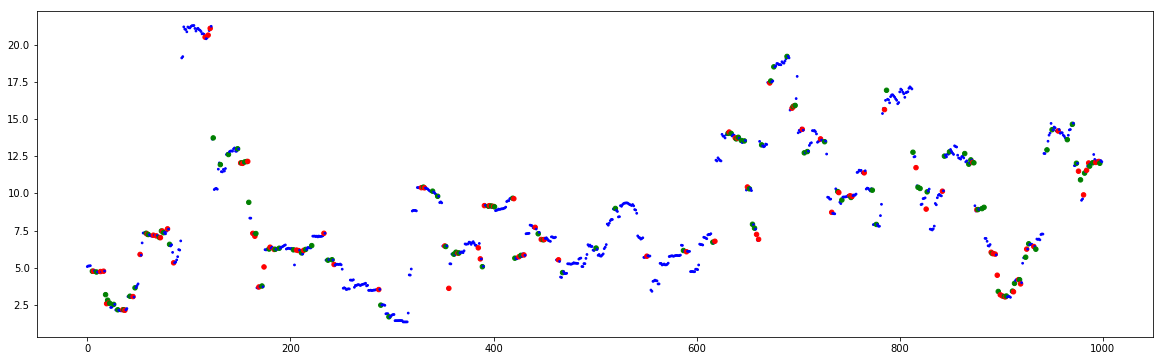

In [299]:
plot_var(train_volume_volatility, label_train, 1000)

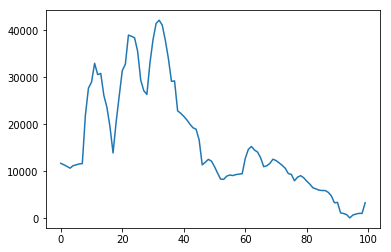

In [272]:
plt.plot(train_price_volatility[:100])

In [256]:
np.savetxt('X_train_feature1.csv', X_train, delimiter=',')
np.savetxt('X_up_test_feature1.csv', X_up_test, delimiter=',')
np.savetxt('X_down_test_feature1.csv', X_down_test, delimiter=',')
np.savetxt('X_updown_test_feature1.csv', X_updown_test, delimiter=',')